# Accessibility analysis Graz-Geidorf

In [1]:
import osmnx as ox
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point
from matplotlib.lines import Line2D

In [ ]:
# Load Data
supermarket_Graz = gpd.read_file("supermarkets.shp")
geidorf = gpd.read_file("geidorf_bezirk.shp")
supermarket_Geidorf = gpd.clip(supermarket_Graz,geidorf)

centroid = supermarket_Geidorf.geometry.centroid
centroid_coords = [(point.x, point.y) for point in centroid]

1. Accessibility 500m

In [ ]:
place_name = "Geidorf, Graz, Austria"
buffer_dist = 500
# Load only Footwalk in Graz-Geidorf
G = ox.graph_from_place(place_name, buffer_dist=buffer_dist, network_type='walk')
# start point = supermarket
start_points = centroid_coords
start_nodes = [ox.distance.nearest_nodes(G, X=lon, Y=lat) for lon, lat in start_points]

max_distance = 500
close_nodes_dict_500 = {}
# Loop for Dijkstra Algorithm for every node under 500m
for start_node in start_nodes:
    lengths = nx.single_source_dijkstra_path_length(G, start_node, weight='length')
    # Dictionary for all found nodes
    close_nodes_dict_500[start_node] = {node for node, dist in lengths.items() if dist <= max_distance}

In [5]:
data = []
# Loop to save found nodes in dataframe
for start_node, nodes in close_nodes_dict_500.items():  
    for node in nodes:
        node_x, node_y = G.nodes[node]['x'], G.nodes[node]['y']
        data.append({
            'node_id': node,
            'start_node': start_node,
            'geometry': Point(node_x, node_y)
        })

nodes_500 = gpd.GeoDataFrame(data, crs="EPSG:4326")

2. Accessibility 1000m

In [ ]:
place_name = "Geidorf, Graz, Austria"
buffer_dist = 500
# Load only Footwalk in Graz-Geidorf
G = ox.graph_from_place(place_name, buffer_dist=buffer_dist, network_type='walk')
# start point = supermarket
start_points = centroid_coords
start_nodes = [ox.distance.nearest_nodes(G, X=lon, Y=lat) for lon, lat in start_points]

max_distance = 1000 
close_nodes_dict_1000 = {}
# Loop for Dijkstra Algorithm for every node under 500m
for start_node in start_nodes:
    lengths = nx.single_source_dijkstra_path_length(G, start_node, weight='length')
    # Dictionary for all found nodes
    close_nodes_dict_1000[start_node] = {node for node, dist in lengths.items() if dist <= max_distance}

In [6]:
data = []
# Loop to save found nodes in dataframe
for start_node, nodes in close_nodes_dict_1000.items():  
    for node in nodes:
        node_x, node_y = G.nodes[node]['x'], G.nodes[node]['y']
        data.append({
            'node_id': node,
            'start_node': start_node,
            'geometry': Point(node_x, node_y)
        })

nodes_1000 = gpd.GeoDataFrame(data, crs="EPSG:4326")

3. Convex Hull for Accessibility Nodes

In [7]:
hulls_500 = nodes_500.dissolve(by='start_node').convex_hull
hull_gdf_500 = gpd.GeoDataFrame(hulls_500, columns=['geometry'], crs="EPSG:4326")

hulls_1000 = nodes_1000.dissolve(by='start_node').convex_hull
hull_gdf_1000 = gpd.GeoDataFrame(hulls_1000, columns=['geometry'], crs="EPSG:4326")

4. Plotting Service Areas of supermarket in Graz-Geidorf

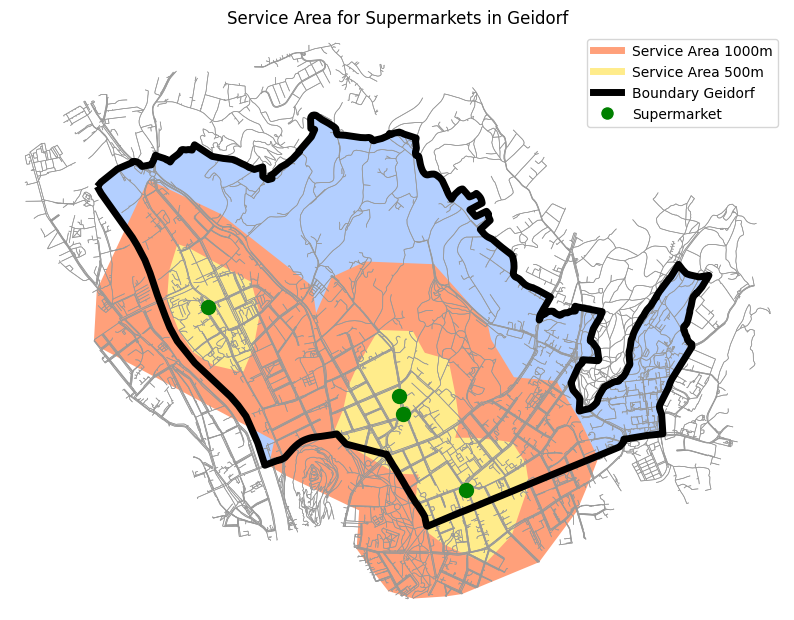

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))

geidorf.plot(ax=ax, color='#b3cfff')

hull_gdf_1000.plot(ax=ax, color = '#FFA07A',legend=True)
hull_gdf_500.plot(ax=ax, color = '#FFEC8B', legend=True)
geidorf.boundary.plot(ax=ax, edgecolor='black', linewidth=5)

ox.plot_graph(G, ax=ax, show=False, close=False, node_size=0, edge_linewidth=0.5)

for lat, lon in start_points:
    ax.plot(lat, lon, 'go', markersize=10)

plt.title("Service Area for Supermarkets in Geidorf")

legend_elements = [
    Line2D([0], [0], color='#FFA07A', lw=5, label='Service Area 1000m'),
    Line2D([0], [0], color='#FFEC8B', lw=5, label='Service Area 500m'),
    Line2D([0], [0], color='black', lw=5, label='Boundary Geidorf'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Supermarket')
]

ax.legend(handles=legend_elements)

plt.savefig('Geidorf.png')

plt.show()